In this first experiment we will look at one of the simplest and most useful types of content to generate: height maps.

We will store these as Python dictionaries whose elements `Z[x,y]` will store the height at position `(x,y)`. Rather than just printing these dictionaries to screen, it would be nicer to see them as an image. So let's define a couple of functions to do just that.

In [1]:
from PIL import Image
from IPython.display import display

def height2image (Z, terrain=None ):
    # converts a heightmap z into a PIL image
    # for terrain=None, this is a black and white image with white for Z[x,y]=1 and black for Z[x,y]=0
    # otherwise, the values in terrain are used as thresholds between sea and beach, beach and grass, etc
    image = {}
    for pos in Z:
        if terrain:
            if Z[pos]<terrain[0]:
                image[pos] = (50,120,200)
            elif Z[pos]<terrain[1]:
                image[pos] = (220,220,10)
            elif Z[pos]<terrain[2]:
                image[pos] = (100,200,0)
            elif Z[pos]<terrain[3]:
                image[pos] = (75,150,0)
            elif Z[pos]<terrain[4]:
                 image[pos] = (200,200,200)  
            else:
                image[pos] = (255,255,255)
        else:
            z = int(255*Z[pos])
            image[pos] = (z,z,z)
            
    img = Image.new('RGB',max(Z.keys()))  
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            img.load()[x,y] = image[x,y]
    return img

def plot_height (Z,terrain=[5/16,6/16,9/16,12/16,14/16],zoom=None):
    # display a heightmap as the above image
    # displayed image is a terrain map by default
    img = height2image(Z,terrain=terrain)
    if zoom:
        img = img.resize((zoom*img.size[0],zoom*img.size[0]), Image.ANTIALIAS)
    img.save('temp.png')
    display(Image.open('temp.png'))

Now we can look at an example of how height maps are usually created. A popular approach is gradient noise, such as the simplex noise generated by the function below.

In [2]:
from opensimplex import OpenSimplex
import random

def simplex(L,period):
    # create a heightmap for an L[0]xL[1] image using simplex noise
    gen = OpenSimplex(seed=random.randint(0,10**20))
    Z = {}
    for x in range(L[0]):
        for y in range(L[1]):
            xx = period[0]*(x/L[0]-0.5)
            yy = period[1]*(y/L[1]-0.5)
            Z[x,y] = gen.noise2d(xx,yy)/2 + 0.5     
    return Z

The input `L` determines the size of the resulting image: using `L=[500,500]` will make an height map of $500\times 500$ positions. This image will have an undulating landscape, with hills in white and valleys in black. The periodicity of this is controled by the input `period`. Let's print an example where this is `[10,10]`.

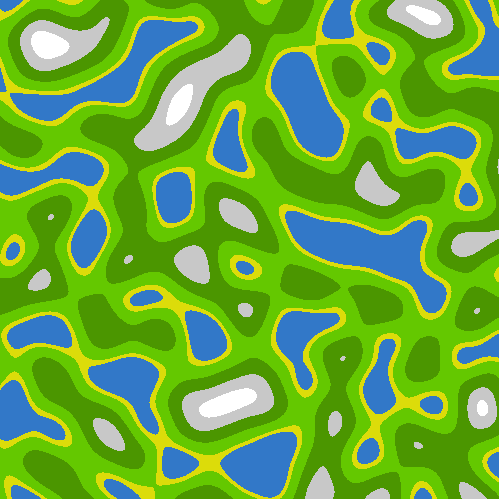

In [3]:
Zlow = simplex([500,500],[10,10])
plot_height( Zlow )

To get something more like a real mountain range, gradient noise of different frequencies can be combined with different weights. as a simple example, let's make a mix with 80% of the same frequency we saw before, and 20% of a higher frequency.

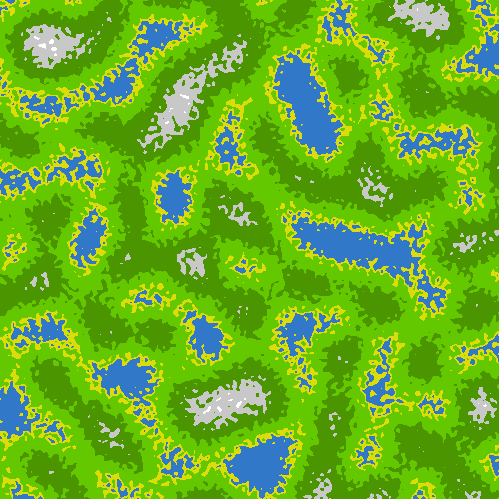

In [4]:
Zhigh = simplex([500,500],[100,100])
Z = { pos: 0.8*Zlow[pos] + 0.2*Zhigh[pos] for pos in Zhigh }
plot_height( Z )

It is our aim to come up with something similar using quantum computing.

First, we need to choose how many qubits to use. If we want to perform a simulation within the timescale of a loading screen, or to use a current prototype device, we shouldn't use too many. Let's start with 10.

In [5]:
n = 10 # for a real device, 6 is recommended

We want to use a small number of qubits, but we also want to generate images with thousands of points. To allow this, we can use the randomness that can appear in outputs of quantum computations. Specifically, for $n$ qubits the output is always a string of $n$ bits. This means $2^n$ different possible outputs. If the output has some randomness, this will be described by $2^n$ corresponding probabilities.

This exponential number can allow us to squeeze as much as we can out of our qubits. By associating each bit string with a point, and the height of the map at that point can be used to define the probability of the string.

The problem with this is getting all the heights out of our quantum program. This will require many repetitions to do statistics on the output and calculate the probablities. We refer to this as the number of `shots`.

In [6]:
shots = 4**n

The exponential number of shots required means that this method is not scalable to large $n$: it has exactly the kind of exponentially increasing run time that quantum computers usually aim to free us from. The method we use here will serve as proof-of-principle for the current era of quantum computing. Future eras will need different methods.

For now, we need to choose a way of assigning each of the possible bit strings to a point. The most natural way to do this would be to respect the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) of the bit strings. This is because the basic operations of quantum computing, single qubit gates and `cx` gates, only have the effect of flipping a single bit in a bit string. Strings that differ by only a single bit can therefore be regarded as 'closer' to each other than those that differ by more.

With this in mind, the set of all $n$-bit strings represents a hypercube: a shape that exists in $n$-dimensional space. This is a bit exotic for our needs, since we want the generate a 2D terrain map like the one depicted above. We therefore need a way to squash a hypercube onto a 2D surface.

This is done in the following cell. The dictionary `strings` is created, which has 2D coordinates `(x,y)` as keys and the corresponding bit string as values. The squashing procedure essentially uses the fact that a cube is two squares, with each point in one connected to its partner in the other. A tesseract is then two cubes connected similarly, and so on for higher dimensional hypercubes. But if we don't include all the possible connections, we can keep our not-quite-a-cube flat, and then do the same with the corresponding not-quite-a-tesseract, and so on.

The result is a square lattice. The four neighbours of each point are four of the $n$ hypercube neighbours of the corresponding string. So the strings are only close to strings that they should be close to, though at the cost of being far away from some of their hypercube neighbours.

In [7]:
import numpy as np

def get_L(n):
    # determine the size of the grid corresponding to n qubits
    Lx = int(2**np.ceil(n/2))
    Ly = int(2**np.floor(n/2))
    return [Lx,Ly]

def make_grid(n):
    # make a dictionary for which every point in the grid is assigned a unique n bit string
    # these are such that '0'*n is in the center, and each string neighbours only its neighbours on the hypercube
    
    [Lx,Ly] = get_L(n)

    strings = {}
    for y in range(Ly):
        for x in range(Lx):
            strings[(x,y)] = ''

    for (x,y) in strings:
        for j in range(n):
            if (j%2)==0:
                xx = np.floor(x/2**(j/2))
                strings[(x,y)] = str( int( ( xx + np.floor(xx/2) )%2 ) ) + strings[(x,y)]
            else:
                yy = np.floor(y/2**((j-1)/2))
                strings[(x,y)] = str( int( ( yy + np.floor(yy/2) )%2 ) ) + strings[(x,y)]

    center = '0'*n
    current_center = strings[ ( int(np.floor(Lx/2)),int(np.floor(Ly/2)) ) ]
    diff = ''
    for j in range(n):
        diff += '0'*(current_center[j]==center[j]) + '1'*(current_center[j]!=center[j])
    for (x,y) in strings:
            newstring = ''
            for j in range(n):
                newstring += strings[(x,y)][j]*(diff[j]=='0') + ('0'*(strings[(x,y)][j]=='1')+'1'*(strings[(x,y)][j]=='0'))*(diff[j]=='1')
            strings[(x,y)] = newstring
            
    grid = {}
    for y in range(Ly):
        for x in range(Lx):
            grid[strings[(x,y)]] = (x,y)
    
    return strings

Now we know which bit strings correspond to which points, we need methods to convert the output of a quantum computer to a heightmap. We'll be using Qiskit to do our quantum computation, which gives an output as a `counts` dictionary. This simply tells us how many of the `shots` repetitions of a quantum program output each bit string. These are therefore essentially unnormalized estimates of the probabilities for each bit string.

To convert a `counts` dictionary into a heightmap, we will simply set the height of a point to be the counts value of the corresponding bit string (an option to use the logarithm instead will also be included). We then normalize the heighmap to make the maximum height equal to 1, and the minimum equal to 0.

In [8]:
def normalize_height(Z):
    # scales heights so that the maximum is 1 and the minimum is 0
    maxZ = max(Z.values())
    minZ = min(Z.values())
    for pos in Z:
        Z[pos] = (Z[pos]-minZ)/(maxZ-minZ)
    return Z

def counts2height(counts,grid,log=False):
    # set the height of a point to be the counts value of the corresponding bit string (or the logarithm) and normalize
    Z = {}
    for pos in grid:
        try:
            Z[pos] = counts[grid[pos]]
        except:
            Z[pos] = 0
    if log:
        for pos in Z:
            Z[pos] = max(Z[pos],1/len(grid)**2)
            Z[pos] = np.log( Z[pos] )/np.log(2)
    Z = normalize_height(Z)    
    return Z

We also need a method that will turn a height map into the input for a quantum computer. These inputs are quantum states, which are expressed as a list of $2^n$ values. We won't get into the technicalities of quantum states here. All you need to know is that the values in this list are known as amplitudes, and that the `j`th amplitude corresponds to the bit string that represents the integer `j`. Specifically, if we were to run the quantum computer immediately after loading the input, the amplitude for each string would be the square root of the probability of that string appearing in the output.

To acheive this for our height map conversion, we set each probability to be the square root of the corresponding height value. Then we normalize to make sure that all the probabilities add up to 1.

In [9]:
def height2state(Z,grid):
    # converts a heightmap intp a quantum state
    N = len(grid)
    state = [0]*N

    for pos in Z:
        state[ int(grid[pos],2) ] = np.sqrt( Z[pos] ) # amplitude is square root of height value
    R = sum(np.absolute(state)**2)
    state = [amp / np.sqrt(R) for amp in state] # amplitudes are normalized
    return state

If we use a simulator of a quantum computer instead of a real one, we can also get it to output a state instead of a `counts` dictionary. In this case we need a way of determining the counts values that we would have gotten. This is done with the function below.

In [10]:
def state2counts (state,shots=None):
    N = len(state)
    n = int(np.log2(N))
    if shots is None:
        shots = N**2
    counts = {}
    for j in range(N):
        string = bin(j)[2:]
        string = '0'*(n-len(string)) + string
        counts[string] = np.absolute(state[j])**2 * shots # square amplitudes to get probabilities
    return counts

To test out these new functions, let's use simplex noise to make a heightmap, generate a grid to associate each positon to a bit string, and then create the corresponding quantum state.

In [11]:
L = get_L(n)
Z = simplex(L,[10,10])

grid = make_grid(n)
state = height2state(Z,grid)

Now let's turn that state into a `counts` dictionary, and make that into a height map.

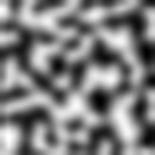

In [12]:
counts = state2counts(state)
Z = counts2height(counts,grid)
plot_height(Z, terrain=None, zoom=5)

That didn't do much of any use (we could have printed the original height map without all the conversions), but at least it seemed to work.

Now let's do something more useful. We'll make a simple height map with just three random points near the middle.

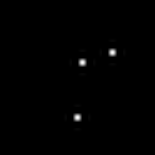

In [13]:
def flat_height(L):
    # create height map that is 0 everywhere
    Z ={}
    for x in range(L[0]):
        for y in range(L[1]):
            Z[x,y] = 0
    return Z

def mountain_seed(L,l,N):
    # create height map of size L with N random points within a box of size l in the middle
    Z = flat_height(L)
    xs = range( int( (L[0]-l[0])/2 ), int( (L[0]+l[0])/2 ) )
    ys = range( int( (L[1]-l[1])/2 ), int( (L[1]+l[1])/2 ) )
    for j in range(N):
        x = random.choice(xs)
        y = random.choice(ys)
        Z[x,y] = 1
        
    return Z

Z = mountain_seed(L,[int(L[0]/2),int(L[1]/2)],3)
plot_height( Z, terrain=None, zoom=5 )

This will be used as the seed for what I'm calling 'quantum tartan'. For this we convert the seed into a state to be be used as an input. Then a simple quantum program is run to blur out the seed using quantum interference. The output is then turned into a height map.

The following function does this, using a simulator by default. To use a real device, get some [IBMQ credentials](https://github.com/Qiskit/qiskit-terra/blob/master/README.md) and set the `shots` argument in the function to the number of shots you'd like to use (must be greater than 1). Ideally this should be something like the value mentioned earlier, but note that 8192 is the maximum that cane be currently used on real devices.

The `seed` argument of the function is the heighmap generated above. The `theta` argument controls the amount of quantum blur that is applied. A pre-made grid can be supplied to the function, or you can just let it generate one itself.

In [14]:
from qiskit import *
import time

def quantum_tartan (seed,theta,grid=None,shots=1,log=True):
        
    n = int(np.log2( len(seed) ))
        
    if grid is None:
        grid = make_grid(n)

    state = height2state(seed,grid)

    q = QuantumRegister(n)
    qc = QuantumCircuit(q)
    qc.initialize(state,q)
    qc.ry(2*np.pi*theta,q)
    
    if shots>1:
        try:
            #IBMQ.load_accounts()
            backend = Aer.get_backend('qasm_simulator')#backend = IBMQ.get_backend('ibmq_16_melbourne')
        except:
            print('An IBMQ account is required to use a real device\nSee https://github.com/Qiskit/qiskit-terra/blob/master/README.md')
    else:
        backend = Aer.get_backend('statevector_simulator')

    if shots>1:
        c = ClassicalRegister(n)
        qc.add_register(c)
        qc.measure(q,c)
    
    start = time.time()
    print('Quantum job initiated on',backend.name())
    job = execute(qc, backend, shots=shots)
    end = time.time()
    print('Quantum job complete after',int(end-start),'seconds')
    

    if shots>1:
        counts = job.result().get_counts()
    else:
        counts = state2counts( job.result().get_statevector() )
        
    Z = counts2height(counts,grid,log=log)   
    
    return Z, grid

Let's try it out!

Quantum job initiated on statevector_simulator
Quantum job complete after 0 seconds


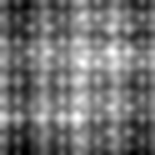

In [15]:
Z, grid = quantum_tartan(Z,0.1) # for a real device, add the argument shots=shots
plot_height( Z, terrain=None, zoom=5 )

Running quantum simulations isn't the fastest thing in the world. And since there are far more people interested in quantum computing than there are quantum computers, getting a result back from current prototype devices can also involve a wait. We therefore need to get as much use out of our quantum results as possible.

To do this, we can use the fact that there are many ways to squash a hypercube. The grid used to generate the image above is not unique, and we can easily get more by simply shuffling all the bit values. This is done by the following functions, in order to generate a new, shuffled version of the height map.

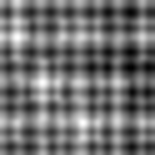

In [16]:
def shuffle_grid(grid):
    
    n = int( np.log(len(grid))/np.log(2) )
    
    order = [j for j in range(n)]
    random.shuffle(order)
    
    new_grid = {}
    for pos in grid:
        new_string = ''
        for j in order:
            new_string = grid[pos][j] + new_string
        new_grid[pos] = new_string
    
    return new_grid

def shuffle_height (Z,grid):
    
    new_grid = shuffle_grid(grid)
    new_Z = {}
    for pos in Z:
        string = grid[pos] 
        new_pos = list(new_grid.keys())[ list(new_grid.values()).index( string ) ]
        new_Z[new_pos] = Z[pos]
        
    return new_Z,new_grid


Z,grid = shuffle_height(Z,grid)
plot_height( Z, terrain=None, zoom=5 )

Despite the shuffling, the quantum tartan will always have a definite grid like pattern. This is not ideal if we are trying to generate something natural looking, like terrain. We'll therefore make use of the following function, which
rotates a height map by a given angle (expressed in radians as a multiple of $\pi$). The heightmap is also made bigger to make sure the image isn't clipped.

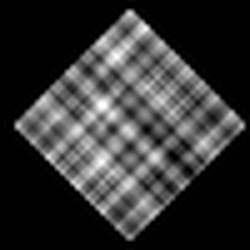

In [17]:
def rotate_height (Z,theta):
    # rotate height Z by angle theta
    L = list(max(Z))
    mid = [(L[j]+1)/2 for j in range(2)]
    
    Lr = [ int( 1.6*(L[j]+1) ) for j in range(2) ]
    midr = [Lr[j]/2 for j in range(2)]
    
    Zr = flat_height(Lr)
    
    for pos in Zr:
        
        d = [ pos[j]-midr[j] for j in range(2) ]
        
        x = int( d[0]*np.cos(theta*np.pi) + d[1]*np.sin(theta*np.pi) + mid[0] )
        y = int( -d[0]*np.sin(theta*np.pi) + d[1]*np.cos(theta*np.pi) + mid[1] )
        
        if (x,y) in Z:
            Zr[pos] = Z[x,y]
        else:
            Zr[pos] = 0
        
    return Zr


plot_height( rotate_height(Z,0.25), terrain=None, zoom=5 )

For the 10 qubits we've used here, the images we are generating are $32\times32$ pixels in size. That's not really enough to make something like a map in which we can play a game. A world in the Raspberry Pi version of Minecraft, for example, is $256\times256$ blocks in size.

To make such a Minecraft world, we can weave together many patches of quantum tartan. For example, let's make 100.

In [18]:
start = time.time()

samples = 300 # for a real device, 5000 is recommended
tartans = []
for j in range(samples):
    randZ,_ =  shuffle_height(Z,grid)
    randZ = rotate_height(randZ,random.random())
    tartans.append( randZ )
    
end = time.time()
print('Generation of',samples,'samples took',int(end-start),'seconds')

Generation of 300 samples took 10 seconds


Next we take some simplex noise and choose random points. The probability of a point being chosen will be higher for points with a higher value. These points are then used as the position for one of our pieces of tartan.

In [19]:
def islands(size,period,tartans):
    # height map of created by combining the quantum tartans of `tartans` using simplex noise defined by `period`
    Z = flat_height(size)
    
    Zs = simplex(size,period)
    
    tsize = max(tartans[0])
    
    for tartan in tartans:  
        unchosen = True
        while unchosen:
            x0 = random.choice(range(size[0]-tsize[0]))
            y0 = random.choice(range(size[1]-tsize[1]))
            if random.random()<Zs[x0,y0]:
                unchosen = False

        for (x,y) in tartan:
            if (x+x0,y+y0) in Z:
                Z[x+x0,y+y0] +=tartan[x,y]
                
    Z = normalize_height(Z)

    return Z

The result is a heightmap made out of quantum tartan, which we can use as terrain in Minecraft.

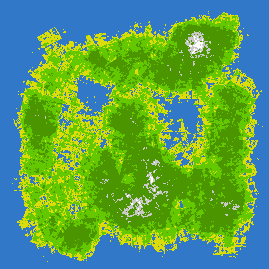

In [20]:
size = [270,270]
period = [3,3]
Z_islands = islands(size,period,tartans)
plot_height( Z_islands, terrain=[2/16,3/16,5/16,10/16,12/16] )

The entire computational time required for this was under a minute. That's a reasonable timescale for a loading screen (though admittedly a bit long). 

It would be nice to do more than just look at 2D maps, and to actually be able to explore the terrain. This can certainly be done, but it isn't simple to do so in Python.

If we wanted to use a voxel based game engine, such as [Minetest](http://www.minetest.net), we would need to know which kind of block to put at each 3D location in a world. The following functions do exactly this. The first creates a dictionary with 3D coordinates as keys and strings describing a material type as values. The second function then saves this as a csv file. This information can then be read in by programs based in any language to turn it into explorable 3D terrain.

Note that, in the following, our coordinates are written in the form `(x,h,y)`. Here `x` and `y` are used in the same way as elsewhere in this notebook, and `h` is a height calculated from the value of `Z[x,y]`. The order used here is to be consistent in the way many 3D renderers work, for which the middle coordinate represents height.

In [21]:
def make_blocks(Z,terrain=[2/16,3/16,5/16,10/16,12/16],height=24,depth=12,offset=50):
    # make a dictionary that determines which material exists at each 3D position
    # also returns mins and maxs of all three coordinates in `mins` and `maxs`
    def addBlocks( blocks, x1,h1,y1, x2,h2,y2, block ):
        # add a blocks of a given type for a given range of coordinates
        for x in range(x1,x2+1):
            for y in range(y1,y2+1):
                for h in range(h1,h2+1):
                    blocks[x,h,y] = block
    
    def addTreeBlocks( blocks, x,h,y, rnd ):
        #Makes a tree, rooted at the specified position'''
        for j in range(1,6):
            blocks[x,h+j,y] = 'tree'
        for xx in range(x-3,x+4):
            for yy in range(y-3,y+4):
                for hh in range(h+5,h+11):
                    d = (xx-x)**2+(yy-y)**2+(hh-h-6)**2 + 0.1
                    if d<8:
                        blocks[xx,hh,yy] = 'leaves'
        xx = choose([x-1,x+1],rnd)
        yy = choose([y-1,y+1],rnd)
        blocks[xx,h+5,yy] = 'tree'
        blocks[xx,h+4,yy] = 'torch'
                              
    def choose( options, rnd ):
        return options [ int(round(rnd*( len(options)-1 ))) ]
    
    
    sea_level = int( depth+terrain[0]*height+1 )
    
    choosing = True
    while choosing:
        spawn = random.choice( list(Z.keys()) )
        if Z[spawn]>terrain[0]:
            choosing = False
    spawn = [spawn[0],offset+depth+height,spawn[1]]
    
    blocks = {}
    (Xmin,Hmin,Ymin) = (0,offset,0)
    (Xmax,Hmax,Ymax) = (0,offset,0)
    for (X,Y) in Z:
        
        Hfloat = depth + Z[X,Y]*height
        H = int( Hfloat ) # height for a block
        rnd = Hfloat-H # value from 0 to 1 that we can use for randomness
        
        Xmin = min(Xmin,X); Ymin = min(Ymin,Y); Hmin = min(Hmin,H)
        Xmax = max(Xmax,X); Ymax = max(Ymax,Y); Hmax = max(Hmax,H)
        
        # First we make a cavern, which is most spacious under hills
        
        Hm = int( (1-Z[X,Y])*depth/2 ) # height for stalagtites
        Ht = int( depth - (1-Z[X,Y])*depth/2 ) #height at which stalagmites begin
        
        if Z[X,Y]<terrain[0]:
            minerals = ['diamondblock','goldblock'] # most precious minerals in hard to reach places
        else:
            minerals = ['stone','stone','stone_with_coal','stone_with_iron','stone_with_copper','stone_with_tin','stone_with_gold','stone_with_diamond']
        stone_m = choose(minerals,rnd)
        stone_t = choose(minerals,1-rnd)
   
        if (1-Z[X,Y])<terrain[0]: # the very bottom of the cavern has lava
            blocks[X,offset+0,Y] = stone_m
            blocks[X,offset+1,Y] = 'lava_source'
        else: # otherwise a mineral
            addBlocks( blocks, X,offset+0,Y, X,offset+Hm,Y, stone_m )
            
        if Z[X,Y]<terrain[4]: # the roof is always a mineral
            addBlocks( blocks, X,offset+Ht,Y, X,offset+depth,Y, stone_t )
        
        if rnd<0.005 and Z[X,Y]>terrain[0] and Z[X,Y]<terrain[4]:
            blocks[X,offset+Ht-1,Y] = 'torch'
                        
        if Z[X,Y]<terrain[0]: # sand at H and then water up to sea level
            addBlocks( blocks, X,offset+depth,Y, X,offset+H,Y, 'sand' )
            addBlocks( blocks, X,offset+H+1,Y, X,offset+sea_level,Y, 'water_source' )
        elif Z[X,Y]<terrain[1]: # sand
            addBlocks( blocks, X,offset+depth+1,Y, X,offset+H-1,Y, 'stone' )
            blocks[X,offset+H,Y] = 'sand'
            blocks[X,offset+H+1,Y] = 'sand'
        elif Z[X,Y]<terrain[2]: # grass with trees
            addBlocks( blocks, X,offset+depth+1,Y, X,offset+H-1,Y, 'stone' )
            blocks[X,offset+H,Y] = 'dirt_with_grass'
            blocks[X,offset+H+1,Y] = 'dirt_with_grass'
            if rnd<0.025:
                addTreeBlocks( blocks, X,offset+H,Y, rnd )
            else:
                blocks[X,offset+H+2,Y] = choose(['fern_1','marram_grass_1','marram_grass_2','marram_grass_3'],rnd)
        elif Z[X,Y]<terrain[3]: # grass with ferns
            addBlocks( blocks, X,offset+depth+1,Y, X,offset+H-1,Y, 'stone' )
            blocks[X,offset+H,Y] = 'dirt_with_grass'
            blocks[X,offset+H+1,Y] = 'dirt_with_grass'
            blocks[X,offset+H+2,Y] = choose(['fern_1','fern_2','fern_3','marram_grass_1'],rnd)
        elif Z[X,Y]<terrain[4]: # mixture of grass and stone
            addBlocks( blocks, X,offset+depth+1,Y, X,offset+H-1,Y, 'stone' )
            if rnd<1/3:
                blocks[X,offset+H,Y] = 'dirt_with_grass'
                blocks[X,offset+H+1,Y] = 'dirt_with_grass'
            else:
                blocks[X,offset+H,Y] = 'stone'
                blocks[X,offset+H+1,Y] = 'stone'
        elif H==(depth + terrain[4]*height): # just stone, with a random bit of additional height
            H += int(height*rnd/10)
            addBlocks( blocks, X,offset+depth+1,Y, X,offset+H+1,Y, 'stone' )
        elif Z[X,Y]==1:
            blocks[X,offset+H,Y] = 'torch'
                
        mins = (Xmin,offset+Hmin,Ymin)
        maxs = (Xmax,offset+Hmax,Ymax)
        
    return blocks, spawn, mins, maxs
    
def save_blocks(blocks,spawn,mins,maxs,filename='../blocks.csv'):
    # saves a dictionary of the form created by the above function as a csv file
    with open(filename, 'w') as file:
        file.write( str(mins[0])+','+str(mins[1])+','+str(mins[2])+',min,\n' )
        file.write( str(maxs[0])+','+str(maxs[1])+','+str(maxs[2])+',max,\n' )
        file.write( str(spawn[0])+','+str(spawn[1])+','+str(spawn[2])+',player,\n' )
        for (x,h,y) in blocks:
            file.write( str(x)+','+str(h)+','+str(y)+','+blocks[x,h,y]+',\n' )

So, finally, let's save our terrain.

In [22]:
blocks, spawn, mins, maxs = make_blocks( Z_islands )
save_blocks( blocks, spawn, mins, maxs )